# Chapter 21 
 Machine Learning for Business Analytics<br>
Concepts, Techniques, and Applications in Python<br>
by Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

Publisher: Wiley; 2nd edition (2024) <br>
<!-- ISBN-13: 978-3031075650 -->

(c) 2024 Galit Shmueli, Peter C. Bruce, Peter Gedeck, Nitin R. Patel

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors.
"Warnings" are for information only and can usually be ignored.
"Errors" will stop execution and need to be fixed in order to get results.

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/sdsa-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Report the problem using the issue tracker at https://github.com/gedeck/sdsa-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [2]:
import zipfile

import mlba
import nltk
import numpy as np
from nltk.stem.snowball import EnglishStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

nltk.download('punkt_tab')  # download the Punkt tokenizer model

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/petergedeck/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [3]:
text = ['this is the first sentence.',
        'this is a second sentence.',
        'the third sentence is here.']

# learn features based on text
count_vect = CountVectorizer()
counts = count_vect.fit_transform(text)

mlba.printTermDocumentMatrix(count_vect, counts)

          S1  S2  S3
first      1   0   0
here       0   0   1
is         1   1   1
second     0   1   0
sentence   1   1   1
the        1   0   1
third      0   0   1
this       1   1   0


In [4]:
text = ['this is the first     sentence!!',
        'this is a second Sentence :)',
        'the third sentence, is here ',
        'forth of all sentences']

# Learn features based on text. Special characters are excluded in the analysis
count_vect = CountVectorizer()
counts = count_vect.fit_transform(text)

mlba.printTermDocumentMatrix(count_vect, counts)

           S1  S2  S3  S4
all         0   0   0   1
first       1   0   0   0
forth       0   0   0   1
here        0   0   1   0
is          1   1   1   0
of          0   0   0   1
second      0   1   0   0
sentence    1   1   1   0
sentences   0   0   0   1
the         1   0   1   0
third       0   0   1   0
this        1   1   0   0


In [5]:
text = ['this is the first     sentence!!',
        'this is a second Sentence :)',
        'the third sentence, is here ',
        'forth of all sentences']

# Learn features based on text. Include special characters that are part of a word
# in the analysis
count_vect = CountVectorizer(token_pattern=r'[a-zA-Z!:)]+')
counts = count_vect.fit_transform(text)

mlba.printTermDocumentMatrix(count_vect, counts)

            S1  S2  S3  S4
:)           0   1   0   0
a            0   1   0   0
all          0   0   0   1
first        1   0   0   0
forth        0   0   0   1
here         0   0   1   0
is           1   1   1   0
of           0   0   0   1
second       0   1   0   0
sentence     0   1   1   0
sentence!!   1   0   0   0
sentences    0   0   0   1
the          1   0   1   0
third        0   0   1   0
this         1   1   0   0


 
The `token_pattern` is a regular expression that specifies the pattern of the tokens. 
Here, the regular expression `[a-zA-Z!:)]+` specifies that the tokens are composed of
one or more letters (both upper and lower case), exclamation marks, colons, and right parentheses.

As regular expression can contain the backslash character (`\`) it is customary to prefix
the string with `r` to indicate that it is a _raw_ string. Regular expressions are powerful,
but can be complex. There are online resources that allow to develop regular expressions 
and test them.

For more details see the Python documentation https://docs.python.org/3/library/re.html

In [6]:
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS
stopWords = sorted(ENGLISH_STOP_WORDS)
ncolumns = 6
nrows= 30

print(f'First {ncolumns * nrows} of {len(stopWords)} stopwords')
for i in range(0, len(stopWords[:(ncolumns * nrows)]), ncolumns):
    print(''.join(word.ljust(13) for word in stopWords[i:(i+ncolumns)]))

First 180 of 318 stopwords
a            about        above        across       after        afterwards   
again        against      all          almost       alone        along        
already      also         although     always       am           among        
amongst      amoungst     amount       an           and          another      
any          anyhow       anyone       anything     anyway       anywhere     
are          around       as           at           back         be           
became       because      become       becomes      becoming     been         
before       beforehand   behind       being        below        beside       
besides      between      beyond       bill         both         bottom       
but          by           call         can          cannot       cant         
co           con          could        couldnt      cry          de           
describe     detail       do           done         down         due          
during       each        

In [7]:
text = ['this is the first     sentence!! ',
        'this is a second Sentence :)',
        'the third sentence, is here ',
        'forth of all sentences']

# Create a custom tokenizer that will use NLTK for tokenizing and stemming
# (removes interpunctuation, stop words, and stems the words)
class StemmingTokenizer:
    def __init__(self):
        self.stemmer = EnglishStemmer()
        self.stopWords = set(ENGLISH_STOP_WORDS)

    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in nltk.word_tokenize(doc)
                if t.isalpha() and t not in self.stopWords]

# Learn features based on text
count_vect = CountVectorizer(tokenizer=StemmingTokenizer(), token_pattern=None)
counts = count_vect.fit_transform(text)

mlba.printTermDocumentMatrix(count_vect, counts)

         S1  S2  S3  S4
forth     0   0   0   1
second    0   1   0   0
sentenc   1   1   1   1


 
The `tokenizer` argument of `CountVectorizer` expects a function. However, here we pass an instance of a class. This works
because the `StemmingTokenizer` class defines the `__call__` method. This is the method that is executed when the instance is used 
like a function. For example,

In [8]:
tokenizer = StemmingTokenizer()
tokenizer(text[1])

['second', 'sentenc']

 
The call `tokenizer(text[1])` is interpreted as `tokenizer.__call__(text[1])`. 

Note, that we initialize a few class variables in the `__init__` method. The `__init__` method is called when the instance is created.
We do this to avoid creating the stop words set and the stemmer for each call to the `__call__` method.

The list comprehension also deserves some explanation. We first use `nltk.word_tokenize` to convert the text into a list of words/tokens. 
We then iterate over this list and keep only the words that are alphabetic (i.e., contain at least one letter) and are not in the stop words set.
Whatever is left is then passed to the `stem` method of the stemmer to reduce it to its stem.

In [9]:
text = ['this is the first     sentence!!',
        'this is a second Sentence :)',
        'the third sentence, is here ',
        'forth of all sentences']

# Apply CountVectorizer and TfidfTransformer sequentially
count_vect = CountVectorizer()
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
counts = count_vect.fit_transform(text)
tfidf = tfidfTransformer.fit_transform(counts)

mlba.printTermDocumentMatrix(count_vect, tfidf)

                 S1        S2        S3        S4
all        0.000000  0.000000  0.000000  2.386294
first      2.386294  0.000000  0.000000  0.000000
forth      0.000000  0.000000  0.000000  2.386294
here       0.000000  0.000000  2.386294  0.000000
is         1.287682  1.287682  1.287682  0.000000
of         0.000000  0.000000  0.000000  2.386294
second     0.000000  2.386294  0.000000  0.000000
sentence   1.287682  1.287682  1.287682  0.000000
sentences  0.000000  0.000000  0.000000  2.386294
the        1.693147  0.000000  1.693147  0.000000
third      0.000000  0.000000  2.386294  0.000000
this       1.693147  1.693147  0.000000  0.000000


In [10]:
# Step 1: import and label records
corpus = []
label = []
with zipfile.ZipFile(mlba.get_data_file('AutoAndElectronics.zip')) as rawData:
    for info in rawData.infolist():
        if info.is_dir():
            continue
        label.append(1 if 'rec.autos' in info.filename else 0)
        corpus.append(rawData.read(info).decode('latin1'))

 
The `ZipFile` class is used to read the zip-files. Zip files contain one or more files in compressed format. We can get a list 
with information about these files with the `infolist()` method; directores are ignored (`is_dir()`).
For each file, we determine the label based on the filename and then read the content of the file and store it in the corpus.
The `read` command reads the content of the file as a byte string which we convert to a string using `decode`. Here, we need
`latin1` encoding to read the content of all files. If this doesn't work, another popular encoding to try is `utf-8`, which is 
the default of the `decode` function and doesn't work here.

In [11]:
# Step 2: preprocessing (tokenization, stemming, and stopwords)
class StemmingTokenizer:
    def __init__(self):
        self.stemmer = EnglishStemmer()
        self.stopWords = set(ENGLISH_STOP_WORDS)
    def __call__(self, doc):
        return [self.stemmer.stem(t) for t in nltk.word_tokenize(doc)
                if t.isalpha() and t not in self.stopWords]

preprocessor = CountVectorizer(tokenizer=StemmingTokenizer(), token_pattern=None)
preprocessedText = preprocessor.fit_transform(corpus)

# Step 3: TF-IDF and latent semantic analysis
tfidfTransformer = TfidfTransformer()
tfidf = tfidfTransformer.fit_transform(preprocessedText)

# Extract 20 concepts using LSA ()
lsa = make_pipeline(TruncatedSVD(20, random_state=123),
                    Normalizer(copy=False))
lsa_tfidf = lsa.fit_transform(tfidf)

 
The `make_pipeline` function is used to chain the `TruncatedSVD` and `Normalizer` objects in a pipeline. In other chapters 
of the book, we used the `Pipeline` class to define models. Both approaches achieve the same result. 
The `TruncatedSVD` uses random numbers; to ensure reproducibility, we set the `random_state` parameter to a fixed value.

In [12]:
# split dataset into 60% training and 40% holdout set
train_X, holdout_X, train_y, holdout_y = train_test_split(lsa_tfidf, label, test_size=0.4,
                                                      random_state=42)

# run logistic regression model on training
logit_reg = LogisticRegression(solver='lbfgs')
logit_reg.fit(train_X, train_y)

# print confusion matrix and accuracty
mlba.classificationSummary(y_true=holdout_y, y_pred=logit_reg.predict(holdout_X))

Confusion Matrix (Accuracy 0.9550)

       Prediction
Actual   0   1
     0 389   8
     1  28 375


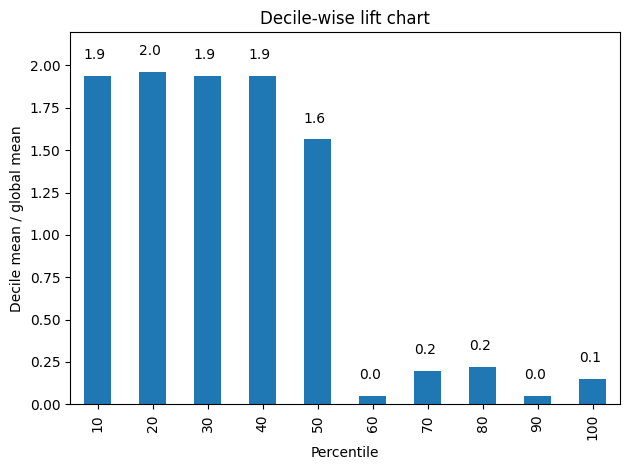

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.DataFrame({'predicted': logit_reg.predict(holdout_X),
                   'actual': holdout_y})
mlba.liftChart(df, ranking='predicted', actual='actual')
%matplotlib inline
plt.tight_layout()
plt.show()

In [14]:
mlba.downloadGloveModel()
embeddings = {}
with (zipfile.Path('glove.6B.zip') / 'glove.6B.100d.txt').open('rt') as f:
    for line in f:
        words = line.strip().split()
        embeddings[words[0]] = np.asarray(words[1:], dtype='float32')

 
The `downloadGloveModel` function downloads the GloVe model from the website and saves it in the current directory. 
It will only do this once. The `zipfile.Path` function is a convenient way of extracting data from a zip file. It is modelled after the `pathlib` module. The `np.asarray` function converts the string representation of the vector to a numpy array.

In [15]:
class SentenceEmbeddingVectorizer:
    def __init__(self, embeddings, *, dim=100):
        self.embeddings = embeddings
        self.dim = dim

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def fit(self, X, y=None):
        pass

    def transform(self, X):
        # for each review, split into words, convert them into embeddings and
        # average all the word embeddings to get a single vector for the review
        return np.array([
            np.mean([self.embeddings.get(word, np.zeros(self.dim))
                    for word in review.split()], axis=0)
            for review in X])

 Example

In [16]:
vectorizer = SentenceEmbeddingVectorizer(embeddings)
vectorizer.transform(['I love this movie', 'I hate this movie'])

array([[ 0.01792   ,  0.2870925 ,  0.4717225 , -0.2865175 ,  0.05754501,
         0.25707325, -0.28171675,  0.02054626,  0.01417   , -0.1215275 ,
        -0.0497575 ,  0.003879  ,  0.005989  ,  0.066245  ,  0.06114025,
         0.09441475,  0.2966415 ,  0.3110445 ,  0.0163825 ,  0.838375  ,
         0.44317999, -0.11438625, -0.023601  , -0.075275  ,  0.4282425 ,
         0.34983249,  0.0554935 , -0.3752075 ,  0.1439255 , -0.2366025 ,
        -0.21039249,  0.52624001,  0.1477065 , -0.04217775,  0.09414576,
         0.26808   ,  0.1159255 ,  0.18586525,  0.09048876, -0.319475  ,
         0.02726825,  0.1982485 , -0.11877307, -0.019885  ,  0.14577025,
        -0.170099  , -0.11631   , -0.3632195 ,  0.18551749, -0.516095  ,
        -0.052525  , -0.1333775 ,  0.40944749,  0.7494825 , -0.0119225 ,
        -2.21842504, -0.04736274,  0.2359325 ,  0.91273001,  0.18095325,
        -0.08274026,  1.04484002, -0.229527  , -0.22429451,  0.54866251,
         0.03288375,  0.62328999,  0.21142775, -0.0

 Partial output

In [17]:
data = mlba.load_data('IMDB-Dataset-10K.csv')
train_X, holdout_X, train_y, holdout_y = train_test_split(data['review'], data['sentiment'],
                                                      test_size=0.2, random_state=1)

model = make_pipeline(SentenceEmbeddingVectorizer(embeddings),
                      LogisticRegression(solver='lbfgs'))
model.fit(train_X, train_y)

mlba.classificationSummary(y_true=holdout_y, y_pred=model.predict(holdout_X))

Confusion Matrix (Accuracy 0.7865)

         Prediction
  Actual negative positive
negative      803      204
positive      223      770


In [18]:
from transformers import AutoTokenizer, AutoModel
import torch

class TransformerEmbeddingVectorizer:
    def __init__(self, model_name="sentence-transformers/all-MiniLM-L6-v2"):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name)

    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def fit(self, X, y=None):
        pass  # no fitting required

    def transform(self, X):
        transformed = []
        for text in X:
            if isinstance(text, bytes):  # decode to string if needed
                text = text.decode(errors='replace')
            # Tokenize the input text and convert to PyTorch tensors
            inputs = self.tokenizer(text, return_tensors="pt", truncation=True, padding=True)
            # Get the model's output
            with torch.no_grad():
                outputs = self.model(**inputs)
            # The embeddings are usually taken from the last hidden state
            embeddings = outputs.last_hidden_state
            # Pool the embeddings (mean pooling for simplicity)
            embedding = embeddings.mean(dim=1).squeeze()
            # Convert to numpy for easier handling if needed
            transformed.append(embedding.cpu().numpy())
        return np.array(transformed)

In [19]:
# save the model to avoid retraining
import joblib
from pathlib import Path

trained_model_filename = Path('transformer_model.joblib')
if trained_model_filename.exists():
    transformer_model = joblib.load(trained_model_filename)
else:
    transformer_model = make_pipeline(TransformerEmbeddingVectorizer(),
                          LogisticRegression(solver='lbfgs'))
    transformer_model.fit(train_X, train_y)
    joblib.dump(transformer_model, trained_model_filename)

In [20]:
mlba.classificationSummary(y_true=holdout_y,
                           y_pred=transformer_model.predict(holdout_X))

Confusion Matrix (Accuracy 0.8255)

         Prediction
  Actual negative positive
negative      834      173
positive      176      817


 Partial output

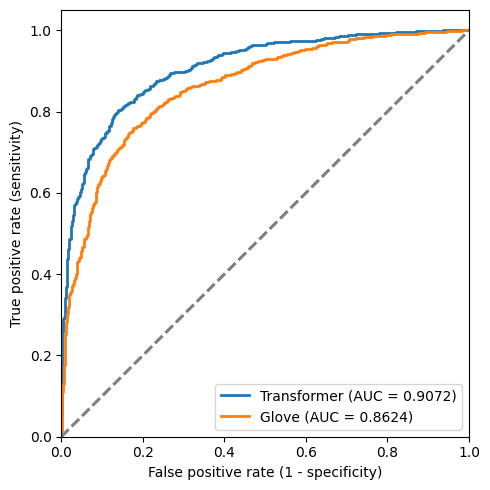

In [21]:
def plotROCcurve(y_true, y_proba, label, *, ax=None, add_diagonal=True):
    # comput ROC curve and AUC
    if ax is None:
        fig, ax = plt.subplots(figsize=[5, 5])
    fpr, tpr, _ = roc_curve(y_true, y_proba, pos_label='positive')
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:0.4f})')
    if add_diagonal:
        ax.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False positive rate (1 - specificity)')
    ax.set_ylabel('True positive rate (sensitivity)')
    ax.legend(loc="lower right")
    return ax

fig, ax = plt.subplots(figsize=[5, 5])
plotROCcurve(holdout_y, transformer_model.predict_proba(holdout_X)[:, 1],
              'Transformer', ax=ax)
plotROCcurve(holdout_y, model.predict_proba(holdout_X)[:, 1],
              'Glove', ax=ax)
plt.tight_layout()
plt.show()